# Data Re-Uploading QCNN_TTN

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/tak/Github/QEmbedding/')
import torch
from torch import nn
import data
import embedding

2024-04-01 23:11:59.966853: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pennylane as qml
from pennylane import numpy as np

In [3]:
dev = qml.device('default.qubit', wires=8)
feature_reduction = 'PCA8'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)

2024-04-01 23:12:01.260455: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Part1: Pre-training the embedding

In [4]:
steps = 1000
learning_rate = 0.01
batch_size = 128
ansatz = 'SU4'

def data_reuploading_ansatz(params): #16 params
    for i in range(8):
        qml.RY(params[i], wires=i)
    for i in range(7):
        qml.IsingZZ(params[i+8], wires=[i,i+1])
    qml.IsingZZ(params[15], wires=[7,0])

def data_reuploading_embedding(num_layers, params, x):
    for l in range(num_layers):
        data_reuploading_ansatz(params[16 * l : 16 * (l + 1)])
        embedding.QuantumEmbedding1(x)


@qml.qnode(dev)
def data_reuploading_QCNN_classifier(num_layers, params, x):
    data_reuploading_embedding(num_layers, params, x)
    embedding.QCNN_eight(params[16 * num_layers: 16 * num_layers + 45], ansatz)
    return qml.expval(qml.PauliZ(4))


def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)


def cost(weights, X_batch, Y_batch, num_layers):
    preds = [data_reuploading_QCNN_classifier(num_layers, weights, x) for x in X_batch]
    return Linear_Loss(Y_batch, preds)


def circuit_training(X_train, Y_train, num_layers):

    if ansatz == 'SU4':
        num_weights = (num_layers * 16) + 45
    elif ansatz == 'TTN':
        num_weights = (num_layers * 16) + 6

    weights = np.random.random(num_weights, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, num_layers),
                                                     weights)
        loss_history.append(cost_new)
        if it % 200 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, weights

In [6]:

Loss_histories_L1, weights_L1, Loss_histories_L2, weights_L2, Loss_histories_L3, weights_L3 = [], [], [], [], [], []
for i in range(5):
    loss_L1, weight_L1 = circuit_training(X_train, Y_train, 1)
    loss_L2, weight_L2 = circuit_training(X_train, Y_train, 2)
    loss_L3, weight_L3 = circuit_training(X_train, Y_train, 3)

    Loss_histories_L1.append(loss_L1)
    Loss_histories_L2.append(loss_L2)
    Loss_histories_L3.append(loss_L3)

    weights_L1.append(weight_L1)
    weights_L2.append(weight_L2)
    weights_L3.append(weight_L3)

f = open('weights_and_loss.txt', 'a')
for i in range(5):
    f.write(f'Loss History L=1 {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_L1[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights L1 {i + 1}:')
    f.write('\n')
    f.write(str(weights_L1[i]))


for i in range(5):
    f.write(f'Loss History L=2 {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_L2[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights L=2 {i + 1}:')
    f.write('\n')
    f.write(str(weights_L2[i]))

for i in range(5):
    f.write(f'Loss History L=3 {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_L3[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights L=3 {i + 1}:')
    f.write('\n')
    f.write(str(weights_L3[i]))
f.close()



iteration:  0  cost:  0.4936612103075455
iteration:  200  cost:  0.4340399339916622
iteration:  400  cost:  0.3497158971160884
iteration:  600  cost:  0.38736088488625814
iteration:  800  cost:  0.3653518093983293
iteration:  0  cost:  0.47408795102098084
iteration:  200  cost:  0.42575530191333005
iteration:  400  cost:  0.34403634134103583
iteration:  600  cost:  0.38653064013958
iteration:  800  cost:  0.38387158452965214
iteration:  0  cost:  0.5029471647548648
iteration:  200  cost:  0.47263317766296276
iteration:  400  cost:  0.41917420631453967
iteration:  600  cost:  0.3765393402245852
iteration:  800  cost:  0.40332695565871624
iteration:  0  cost:  0.5098785387275813
iteration:  200  cost:  0.39585390576187374
iteration:  400  cost:  0.35627092062098603
iteration:  600  cost:  0.37490340276857187
iteration:  800  cost:  0.35458061351158415
iteration:  0  cost:  0.47925982096039776
iteration:  200  cost:  0.3858720224029917
iteration:  400  cost:  0.3696191222663135
iteration:

# Part 4: Result 

Load the results

In [5]:
PATH_LH = 'Loss.txt'
PATH_w = 'Weights.txt'

def data_read(PATH):
  textfile = open(PATH, 'r')
  data = np.array([])
  for line in textfile:
    a = np.array([float(v) for v in line.strip().split(" ")])
    data = np.append(data, a)
  return data

Loss_history = data_read(PATH_LH).reshape(6,5,1000)
Loss_history_L1, Loss_history_L2, Loss_history_L3 = Loss_history[0], Loss_history[1], Loss_history[2]
Loss_histiry_without_NQE, Loss_history_PCA_NQE, Loss_history_NQE = Loss_history[3], Loss_history[4], Loss_history[5]

Weights = data_read(PATH_w)
Weights_L1 = Weights[0:61*5].reshape(5, 61)
Weights_L2 = Weights[61*5: 61*5 + 77*5].reshape(5, 77)
Weights_L3 = Weights[61*5 + 77*5: 61*5 + 77*5 + 93*5].reshape(5, 93)

Loss_history_L1_mean, Loss_history_L1_std = Loss_history_L1.mean(axis=0), Loss_history_L1.std(axis=0)
Loss_history_L2_mean, Loss_history_L2_std = Loss_history_L2.mean(axis=0), Loss_history_L2.std(axis=0)
Loss_history_L3_mean, Loss_history_L3_std = Loss_history_L3.mean(axis=0), Loss_history_L3.std(axis=0)
Loss_history_PCA_NQE_mean, Loss_history_PCA_NQE_std = Loss_history_PCA_NQE.mean(axis=0), Loss_history_PCA_NQE.std(axis=0)
Loss_history_NQE_mean, Loss_history_NQE_std = Loss_history_NQE.mean(axis=0), Loss_history_NQE.std(axis=0)
Weights_L1_mean, Weigths_L1_std = Weights_L1.mean(axis=0), Weights_L1.std(axis=0)
Weights_L2_mean, Weigths_L2_std = Weights_L2.mean(axis=0), Weights_L2.std(axis=0)
Weights_L3_mean, Weigths_L3_std = Weights_L3.mean(axis=0), Weights_L3.std(axis=0)

Plot the results for Model 1,2,3

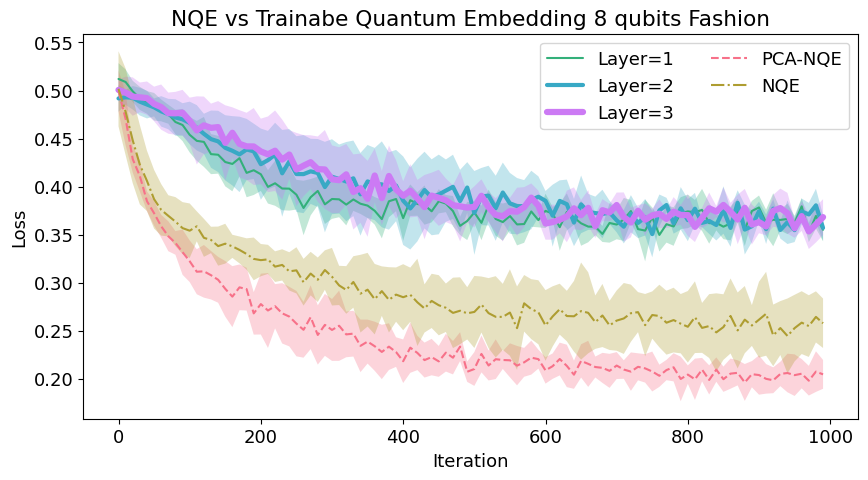

In [13]:
import seaborn as sns
#converged_NQES = (Loss_history_PCA_NQE_mean[800:1000].mean() + Loss_history_NQE_mean[800:1000].mean())/2
#LB_with_PCA_NQE = 0.5 * (1 - 0.8764684796333313)
#LB_with_NQE = 0.5 * (1 - 0.914618194103241)
n = 10
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 5)
with sns.axes_style("darkgrid"):
    #ax.plot(range(1000), np.ones(1000) * LB_with_PCA_NQE, linestyle='dashed', linewidth=3, label="Lower Bound PCA-NQE", c=clrs[0])
    #ax.plot(range(1000), np.ones(1000) * LB_with_NQE, linestyle='dashdot', linewidth=3, label="Lower Bound NQE", c=clrs[1])
    #ax.plot(range(1000), np.ones(1000) * converged_NQES, linestyle='dashed', linewidth=3, label="Converged NQE Losses", c=clrs[0])

    ax.plot(np.array(range(len(Loss_history_L1_mean[::n]))) * n, Loss_history_L1_mean[::n], linewidth=1.5, label="Layer=1", c=clrs[2])
    ax.fill_between(np.array(range(len(Loss_history_L1_mean[::n]))) * n, Loss_history_L1_mean[::n]-Loss_history_L1_std[::n], Loss_history_L1_mean[::n]+Loss_history_L1_std[::n], alpha=0.3,facecolor=clrs[2])

    ax.plot(np.array(range(len(Loss_history_L2_mean[::n]))) * n, Loss_history_L2_mean[::n], linewidth=3, label="Layer=2", c=clrs[3])
    ax.fill_between(np.array(range(len(Loss_history_L2_mean[::n]))) * n, Loss_history_L2_mean[::n]-Loss_history_L2_std[::n], Loss_history_L2_mean[::n]+Loss_history_L2_std[::n], alpha=0.3,facecolor=clrs[3])
    
    ax.plot(np.array(range(len(Loss_history_L3_mean[::n]))) * n, Loss_history_L3_mean[::n], linewidth=4.5, label="Layer=3", c=clrs[4])
    ax.fill_between(np.array(range(len(Loss_history_L3_mean[::n]))) * n, Loss_history_L3_mean[::n]-Loss_history_L3_std[::n], Loss_history_L3_mean[::n]+Loss_history_L3_std[::n], alpha=0.3,facecolor=clrs[4])

    ax.plot(np.array(range(len(Loss_history_PCA_NQE_mean[::n]))) * n, Loss_history_PCA_NQE_mean[::n], label="PCA-NQE", linestyle='dashed', c=clrs[0])
    ax.fill_between(np.array(range(len(Loss_history_PCA_NQE_mean[::n]))) * n, Loss_history_PCA_NQE_mean[::n]-Loss_history_PCA_NQE_std[::n], Loss_history_PCA_NQE_mean[::n]+Loss_history_PCA_NQE_std[::n], alpha=0.3,facecolor=clrs[0])

    ax.plot(np.array(range(len(Loss_history_NQE_mean[::n]))) * n, Loss_history_NQE_mean[::n], label="NQE", linestyle='dashdot', c=clrs[1])
    ax.fill_between(np.array(range(len(Loss_history_NQE_mean[::n]))) * n, Loss_history_NQE_mean[::n]-Loss_history_NQE_std[::n], Loss_history_NQE_mean[::n]+Loss_history_NQE_std[::n], alpha=0.3,facecolor=clrs[1])



ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("NQE vs Trainabe Quantum Embedding 8 qubits Fashion")
ax.legend(fontsize=13, ncol=2)
plt.savefig("Loss History 8 qubits Fashion.pdf")

Calculate the classification accuracies for Model1,2

In [9]:
feature_reduction = 'PCA8'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)

X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

2024-03-28 21:47:12.165894: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/tmp/ipykernel_195625/2628186153.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)


In [13]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)


accuracies_L1, accuracies_L2, accuracies_L3 = [], [], []

for i in range(5):
    prediction_L1 = [data_reuploading_QCNN_classifier(1, Weights_L1[i], x) for x in X_test]
    prediction_L2 = [data_reuploading_QCNN_classifier(2, Weights_L2[i], x) for x in X_test]
    prediction_L3 = [data_reuploading_QCNN_classifier(3, Weights_L3[i], x) for x in X_test]
    
    accuracy_L1 = accuracy_test(prediction_L1, Y_test)
    accuracy_L2 = accuracy_test(prediction_L2, Y_test)
    accuracy_L3 = accuracy_test(prediction_L3, Y_test)

    accuracies_L1.append(accuracy_L1)
    accuracies_L2.append(accuracy_L2)
    accuracies_L3.append(accuracy_L3)

accuracies_Loss_history_L1 = np.array(accuracies_L1)
accuracies_Loss_history_L2 = np.array(accuracies_L2)
accuracies_Loss_history_L3 = np.array(accuracies_L3)

In [15]:

print("Trainable Quantum Embeddings Accuracies:\n")
print("-------------------------------------\n")
print(f" L=1 Accuracy: {accuracies_Loss_history_L1.mean()} ± {accuracies_Loss_history_L1.std()}")
print(f" L=2 Accuracy: {accuracies_Loss_history_L2.mean()} ± {accuracies_Loss_history_L2.std()}")
print(f" L=3 Accuracy: {accuracies_Loss_history_L3.mean()} ± {accuracies_Loss_history_L3.std()}")


Trainable Quantum Embeddings Accuracies:

-------------------------------------

 L=1 Accuracy: 0.9289 ± 0.007559100475585681
 L=2 Accuracy: 0.9205 ± 0.0035355339059327533
 L=3 Accuracy: 0.93 ± 0.004183300132670373


In [6]:
def get_trace_distance(num_layers, params, train):
    feature_reduction = 'PCA8'
    classes = [0,1]
    X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)

    X1_test, X0_test = [], []
    for i in range(len(X_test)):
        if Y_test[i] == 1:
            X1_test.append(X_test[i])
        else:
            X0_test.append(X_test[i])
    X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)

    X1_train, X0_train = [], []
    for i in range(len(X_train)):
        if Y_train[i] == 1:
            X1_train.append(X_train[i])
        else:
            X0_train.append(X_train[i])
    X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)

    @qml.qnode(dev, interface='torch')
    def Circuit_distance(inputs):
        data_reuploading_embedding(num_layers, params, inputs)
        return qml.density_matrix(wires=range(8))

    class Distance(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.qlayer1 = qml.qnn.TorchLayer(Circuit_distance, weight_shapes={})
    
        def forward(self, x1, x0):
            rhos1 = self.qlayer1(x1)
            rhos0 = self.qlayer1(x0)

            rho1 = torch.sum(rhos1, dim=0) / len(x1)
            rho0 = torch.sum(rhos0, dim=0) / len(x0)
            rho_diff = rho1 - rho0
            eigvals = torch.linalg.eigvals(rho_diff)
            return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))
        
    distance = Distance()
    if train:
        return distance(X1_train, X0_train)
    else:
        return distance(X1_test, X0_test)

In [7]:
paramsL1_1 = Weights_L1[0][:16]
paramsL1_2 = Weights_L1[1][:16]
paramsL1_3 = Weights_L1[2][:16]
paramsL1_4 = Weights_L1[3][:16]
paramsL1_5 = Weights_L1[4][:16]

trace_distanceL1_1 = get_trace_distance(1, paramsL1_1, True)
trace_distanceL1_2 = get_trace_distance(1, paramsL1_2, True)
trace_distanceL1_3 = get_trace_distance(1, paramsL1_3, True)
trace_distanceL1_4 = get_trace_distance(1, paramsL1_4, True)
trace_distanceL1_5 = get_trace_distance(1, paramsL1_5, True)

paramsL2_1 = Weights_L2[0][:32]
paramsL2_2 = Weights_L2[1][:32]
paramsL2_3 = Weights_L2[2][:32]
paramsL2_4 = Weights_L2[3][:32]
paramsL2_5 = Weights_L2[4][:32]

trace_distanceL2_1 = get_trace_distance(2, paramsL2_1, True)
trace_distanceL2_2 = get_trace_distance(2, paramsL2_2, True)
trace_distanceL2_3 = get_trace_distance(2, paramsL2_3, True)
trace_distanceL2_4 = get_trace_distance(2, paramsL2_4, True)
trace_distanceL2_5 = get_trace_distance(2, paramsL2_5, True)

paramsL3_1 = Weights_L3[0][:48]
paramsL3_2 = Weights_L3[1][:48]
paramsL3_3 = Weights_L3[2][:48]
paramsL3_4 = Weights_L3[3][:48]
paramsL3_5 = Weights_L3[4][:48]

trace_distanceL3_1 = get_trace_distance(3, paramsL3_1, True)
trace_distanceL3_2 = get_trace_distance(3, paramsL3_2, True)
trace_distanceL3_3 = get_trace_distance(3, paramsL3_3, True)
trace_distanceL3_4 = get_trace_distance(3, paramsL3_4, True)
trace_distanceL3_5 = get_trace_distance(3, paramsL3_5, True)

trace_distances_L1 = np.array([trace_distanceL1_1, trace_distanceL1_2, trace_distanceL1_3, trace_distanceL1_4, trace_distanceL1_5])
trace_distances_L2 = np.array([trace_distanceL2_1, trace_distanceL2_2, trace_distanceL2_3, trace_distanceL2_4, trace_distanceL2_5])
trace_distances_L3 = np.array([trace_distanceL3_1, trace_distanceL3_2, trace_distanceL3_3, trace_distanceL3_4, trace_distanceL3_5])
print(f"Trace distances for L=1: {trace_distances_L1.mean()} ± {trace_distances_L1.std()}")
print(f"Trace distances for L=2: {trace_distances_L2.mean()} ± {trace_distances_L2.std()}")
print(f"Trace distances for L=3: {trace_distances_L3.mean()} ± {trace_distances_L3.std()}")

/tmp/ipykernel_234859/3666946323.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/qnn/torch.py:331: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  return res.type(x.dtype)
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/ma

Trace distances for L=1: 0.3975798189640045 ± 0.007835835218429565
Trace distances for L=2: 0.3145989775657654 ± 0.011480780318379402
Trace distances for L=3: 0.2929510474205017 ± 0.0048987893387675285


In [8]:
paramsL1_1 = Weights_L1[0][:16]
paramsL1_2 = Weights_L1[1][:16]
paramsL1_3 = Weights_L1[2][:16]
paramsL1_4 = Weights_L1[3][:16]
paramsL1_5 = Weights_L1[4][:16]

trace_distanceL1_1 = get_trace_distance(1, paramsL1_1, False)
trace_distanceL1_2 = get_trace_distance(1, paramsL1_2, False)
trace_distanceL1_3 = get_trace_distance(1, paramsL1_3, False)
trace_distanceL1_4 = get_trace_distance(1, paramsL1_4, False)
trace_distanceL1_5 = get_trace_distance(1, paramsL1_5, False)

paramsL2_1 = Weights_L2[0][:32]
paramsL2_2 = Weights_L2[1][:32]
paramsL2_3 = Weights_L2[2][:32]
paramsL2_4 = Weights_L2[3][:32]
paramsL2_5 = Weights_L2[4][:32]

trace_distanceL2_1 = get_trace_distance(2, paramsL2_1, False)
trace_distanceL2_2 = get_trace_distance(2, paramsL2_2, False)
trace_distanceL2_3 = get_trace_distance(2, paramsL2_3, False)
trace_distanceL2_4 = get_trace_distance(2, paramsL2_4, False)
trace_distanceL2_5 = get_trace_distance(2, paramsL2_5, False)

paramsL3_1 = Weights_L3[0][:48]
paramsL3_2 = Weights_L3[1][:48]
paramsL3_3 = Weights_L3[2][:48]
paramsL3_4 = Weights_L3[3][:48]
paramsL3_5 = Weights_L3[4][:48]

trace_distanceL3_1 = get_trace_distance(3, paramsL3_1, False)
trace_distanceL3_2 = get_trace_distance(3, paramsL3_2, False)
trace_distanceL3_3 = get_trace_distance(3, paramsL3_3, False)
trace_distanceL3_4 = get_trace_distance(3, paramsL3_4, False)
trace_distanceL3_5 = get_trace_distance(3, paramsL3_5, False)

trace_distances_L1 = np.array([trace_distanceL1_1, trace_distanceL1_2, trace_distanceL1_3, trace_distanceL1_4, trace_distanceL1_5])
trace_distances_L2 = np.array([trace_distanceL2_1, trace_distanceL2_2, trace_distanceL2_3, trace_distanceL2_4, trace_distanceL2_5])
trace_distances_L3 = np.array([trace_distanceL3_1, trace_distanceL3_2, trace_distanceL3_3, trace_distanceL3_4, trace_distanceL3_5])
print(f"Trace distances for L=1: {trace_distances_L1.mean()} ± {trace_distances_L1.std()}")
print(f"Trace distances for L=2: {trace_distances_L2.mean()} ± {trace_distances_L2.std()}")
print(f"Trace distances for L=3: {trace_distances_L3.mean()} ± {trace_distances_L3.std()}")

/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dis

Trace distances for L=1: 0.4268130362033844 ± 0.009218694642186165
Trace distances for L=2: 0.35471004247665405 ± 0.007531106472015381
Trace distances for L=3: 0.34078386425971985 ± 0.003576908726245165
